## 1. Setting up Google Colab & Drive

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 2. Create Project Directory
import os
project_path = "/content/drive/MyDrive/Crypto_ML_Project"
if not os.path.exists(project_path):
    os.makedirs(project_path)
    print(f"Created project folder at: {project_path}")
else:
    print(f"Project folder already exists at: {project_path}")

Created project folder at: /content/drive/MyDrive/Crypto_ML_Project


In [ ]:
# 3. Install Necessary Libraries
!pip install ccxt pandas numpy matplotlib ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.8/223.8 kB 17.7 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6a414ab3a70b639422a61701b7ddee727bc829fe8094346b56cd0ba0424d4112
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


## 2. The Data Downloader

In [ ]:
import ccxt
import pandas as pd
from datetime import datetime
import time

def fetch_historical_data(symbol='BTC/USDT', timeframe='1h', limit=1000):
    exchange = ccxt.binance()
    all_ohlcv = []

    # We will fetch 10,000 candles (approx 1.2 years of 1H data)
    # Adjust 'since' if you want to go further back
    since = exchange.parse8601('2021-01-01T00:00:00Z')

    print(f"Starting data download for {symbol}...")

    while len(all_ohlcv) < 10000:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
            if len(ohlcv) == 0:
                break
            since = ohlcv[-1][0] + 1  # Move to the next timestamp
            all_ohlcv.extend(ohlcv)
            print(f"Fetched {len(all_ohlcv)} rows...")
            time.sleep(exchange.rateLimit / 1000) # Respect rate limits
        except Exception as e:
            print(f"Error: {e}")
            break

    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Execute Download
df_btc = fetch_historical_data()

# Save to Google Drive
file_path = f"{project_path}/BTC_1H_historical.csv"
df_btc.to_csv(file_path, index=False)
print(f"Success! Data saved to {file_path}")

# Show preview
df_btc.head()

Starting data download for BTC/USDT...
Fetched 1000 rows...
Fetched 2000 rows...
Fetched 3000 rows...
Fetched 4000 rows...
Fetched 5000 rows...
Fetched 6000 rows...
Fetched 7000 rows...
Fetched 8000 rows...
Fetched 9000 rows...
Fetched 10000 rows...
Success! Data saved to /content/drive/MyDrive/Crypto_ML_Project/BTC_1H_historical.csv


,timestamp,open,high,low,close,volume
0,2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445
1,2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471
2,2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560
3,2021-01-01 03:00:00,29195.25,29367.00,29150.02,29278.40,1461.345077
4,2021-01-01 04:00:00,29278.41,29395.00,29029.40,29220.31,2038.046803


Why we did this:
1. CCXT: This is the standard library for crypto. It allows us to switch from Binance to any other exchange (Kraken, Coinbase) later by changing one line of code.
2. Persistence: By saving to /content/drive/MyDrive/Crypto_ML_Project/, we ensure that even if the Colab session expires, we don't have to download the data again.
3. The CSV: This CSV will be the "Source of Truth" for Step 2 (Feature Engineering).

## 3. Feature Engineering & Target Labeling

In [ ]:
import pandas as pd
import numpy as np
import ta  # Technical Analysis library
import matplotlib.pyplot as plt

# 1. Load the data we saved in Step 1
project_path = "/content/drive/MyDrive/Crypto_ML_Project"
file_path = f"{project_path}/BTC_1H_historical.csv"
df = pd.read_csv(file_path, parse_dates=['timestamp'])

print(f"Loaded {len(df)} rows.")

# 2. Feature Engineering (Technical Indicators)
# Momentum
df['rsi'] = ta.momentum.RSIIndicator(close=df['close'], window=14).rsi()
df['stoch_osc'] = ta.momentum.StochasticOscillator(high=df['high'], low=df['low'], close=df['close'], window=14).stoch()

# Volatility
df['atr'] = ta.volatility.AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=14).average_true_range()
df['bb_width'] = ta.volatility.BollingerBands(close=df['close']).bollinger_wband()

# Trend
df['ema_fast'] = ta.trend.ema_indicator(close=df['close'], window=20)
df['ema_slow'] = ta.trend.ema_indicator(close=df['close'], window=50)
df['ema_diff'] = (df['ema_fast'] - df['ema_slow']) / df['ema_slow'] # Percentage difference

# 3. Stationarity: Log Returns (Crucial for Jansen-style modeling)
# We calculate returns for different lookback periods
df['return_1h'] = np.log(df['close'] / df['close'].shift(1))
df['return_4h'] = np.log(df['close'] / df['close'].shift(4))
df['return_24h'] = np.log(df['close'] / df['close'].shift(24))

# 4. Target Labeling (The Variable 'y')
# We want to predict the Log Return of the NEXT hour.
# We shift the 1h return back by 1 so that 'today's features' align with 'tomorrow's return'.
df['target'] = df['return_1h'].shift(-1)

# 5. Cleanup
# Technical indicators create NaN values at the start (e.g., RSI needs 14 periods)
# The target creates a NaN at the very end.
df.dropna(inplace=True)

# 6. Save the Engineered Dataset
processed_file_path = f"{project_path}/BTC_1H_processed.csv"
df.to_csv(processed_file_path, index=False)

print(f"Feature Engineering Complete. New shape: {df.shape}")
print(f"Processed data saved to: {processed_file_path}")
df.head()

Loaded 10000 rows.
Feature Engineering Complete. New shape: (9950, 17)
Processed data saved to: /content/drive/MyDrive/Crypto_ML_Project/BTC_1H_processed.csv


,timestamp,open,high,low,close,volume,rsi,stoch_osc,atr,bb_width,ema_fast,ema_slow,ema_diff,return_1h,return_4h,return_24h,target
49,2021-01-03 01:00:00,32447.95,32790.07,32201.00,32585.09,3401.152207,64.372571,79.910414,712.661304,15.713874,31474.381470,30482.293529,0.032546,0.004218,0.027709,0.104240,0.004794
50,2021-01-03 02:00:00,32583.04,32884.09,32550.00,32741.67,2017.209759,65.456131,81.389000,685.620497,15.355912,31595.075615,30570.896528,0.033502,0.004794,0.018371,0.110248,-0.005138
51,2021-01-03 03:00:00,32741.68,32756.00,32404.00,32573.87,2125.878800,63.236520,75.795667,661.790461,14.701926,31688.294128,30649.444507,0.033895,-0.005138,0.012217,0.104151,0.018814
52,2021-01-03 04:00:00,32576.11,33250.00,32450.00,33192.53,3436.070984,67.598966,96.417667,671.662571,14.282973,31831.554687,30749.173350,0.035200,0.018814,0.022688,0.123045,0.016912
53,2021-01-03 05:00:00,33192.53,34180.00,33109.44,33758.67,10355.070315,70.991297,89.140979,700.155245,13.711272,32015.089479,30867.192826,0.037188,0.016912,0.035382,0.131801,0.006156


## 4. Model Training & Evaluation

--- Model Results ---
Training samples: 7960 | Testing samples: 1990
Directional Accuracy: 48.39%
MSE: 0.000050
Model saved to: /content/drive/MyDrive/Crypto_ML_Project/xgboost_btc_model.json


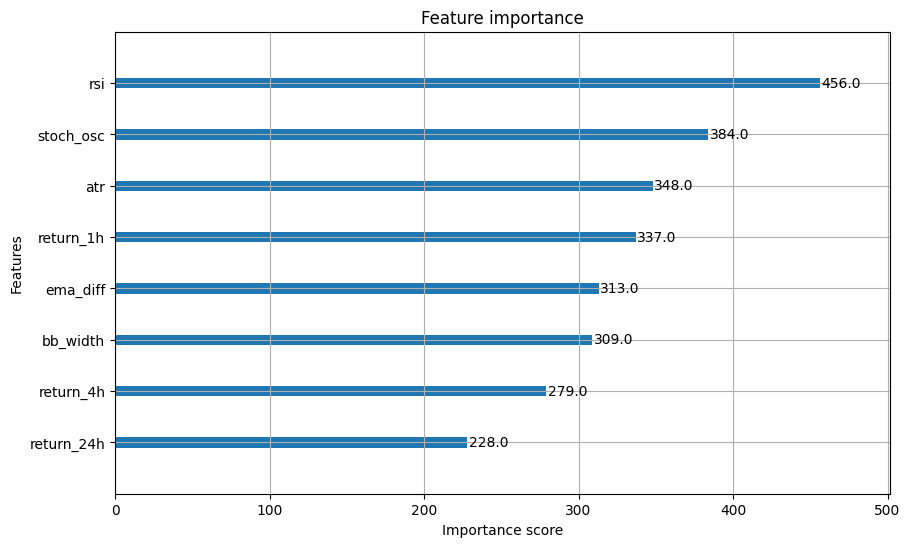

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# 1. Load the processed data
project_path = "/content/drive/MyDrive/Crypto_ML_Project"
df = pd.read_csv(f"{project_path}/BTC_1H_processed.csv")

# 2. Define Features (X) and Target (y)
features = ['rsi', 'stoch_osc', 'atr', 'bb_width', 'ema_diff', 'return_1h', 'return_4h', 'return_24h']
target = 'target'

X = df[features]
y = df[target]

# 3. Time-Series Split (80% Train, 20% Test)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 4. Initialize XGBoost with Early Stopping in the Constructor
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    early_stopping_rounds=50  # Moved here for newer XGBoost versions
)

# 5. Fit the model
# We pass the eval_set directly. Early stopping is handled automatically now.
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# 6. Predictions & Evaluation
y_pred = model.predict(X_test)

# Calculate Directional Accuracy
actual_direction = np.sign(y_test)
# Handle potential zeros in sign by making them 1 (bullish bias for simplicity)
actual_direction = actual_direction.replace(0, 1)

predicted_direction = np.sign(y_pred)
predicted_direction = np.where(predicted_direction == 0, 1, predicted_direction)

dir_accuracy = accuracy_score(actual_direction, predicted_direction)

print(f"--- Model Results ---")
print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")
print(f"Directional Accuracy: {dir_accuracy:.2%}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")

# 7. Save the Model to Google Drive
model_save_path = f"{project_path}/xgboost_btc_model.json"
model.save_model(model_save_path)
print(f"Model saved to: {model_save_path}")

# 8. Feature Importance Visualization
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, ax=ax)
plt.show()

## 5. Vectorized Backtesting.

--- Backtest Results (Test Period) ---
Total Strategy Return: -52.59%
Max Drawdown: -53.98%
Final Balance: $474.06
Buy & Hold Final Balance: $611.87


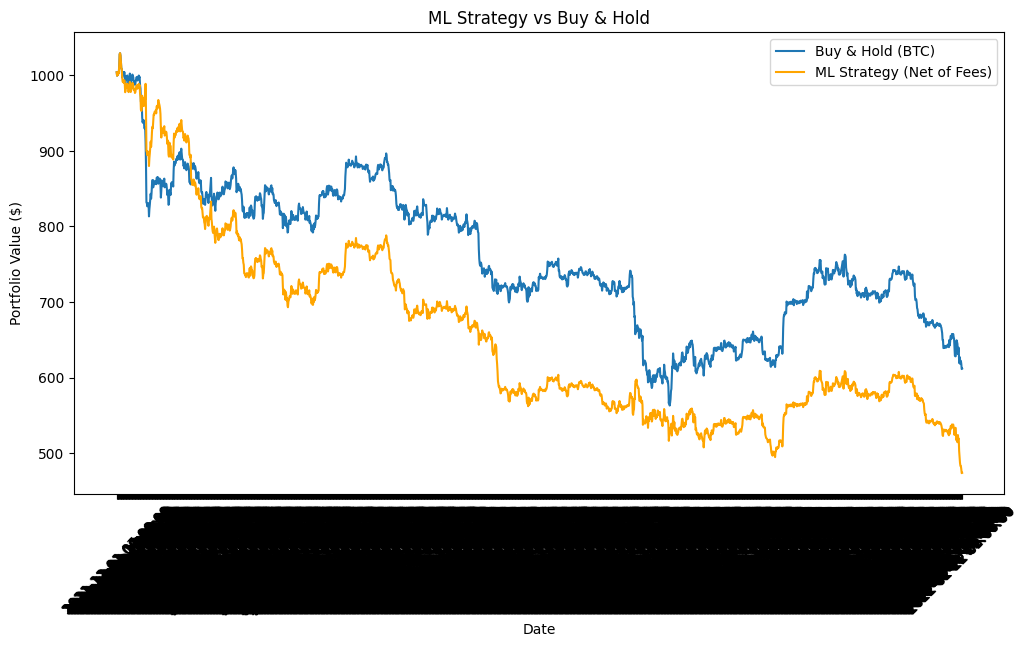

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the processed data to get the price history for the test period
project_path = "/content/drive/MyDrive/Crypto_ML_Project"
df = pd.read_csv(f"{project_path}/BTC_1H_processed.csv")

# 2. Re-create the test split (same as in Step 3)
split_index = int(len(df) * 0.8)
test_df = df.iloc[split_index:].copy()

# 3. Add the predictions from our model
# We need to reload the model first to make sure we are using the saved one
import xgboost as xgb
model = xgb.XGBRegressor()
model.load_model(f"{project_path}/xgboost_btc_model.json")

features = ['rsi', 'stoch_osc', 'atr', 'bb_width', 'ema_diff', 'return_1h', 'return_4h', 'return_24h']
test_df['prediction'] = model.predict(test_df[features])

# 4. Define the Strategy Logic
# We trade based on the prediction. If prediction > 0 -> Long (+1), if < 0 -> Short (-1)
test_df['signal'] = np.where(test_df['prediction'] > 0, 1, -1)

# 5. Calculate Strategy Returns
# 'target' is the actual return of the next candle.
test_df['strategy_return'] = test_df['signal'] * test_df['target']

# 6. Factor in Transaction Costs (Binance spot fees are usually 0.1% or 0.001)
# Costs are applied whenever the signal changes (a trade happens)
fees = 0.001
test_df['trades'] = test_df['signal'].diff().fillna(0).abs()
test_df['strategy_net_return'] = test_df['strategy_return'] - (test_df['trades'] * fees)

# 7. Calculate Cumulative Wealth (Starting with $1,000)
test_df['cum_bh_return'] = (1 + test_df['target']).cumprod() * 1000  # Buy & Hold
test_df['cum_strategy_return'] = (1 + test_df['strategy_net_return']).cumprod() * 1000

# 8. Performance Metrics
total_return = (test_df['cum_strategy_return'].iloc[-1] / 1000) - 1
max_drawdown = (test_df['cum_strategy_return'] / test_df['cum_strategy_return'].cummax() - 1).min()

print(f"--- Backtest Results (Test Period) ---")
print(f"Total Strategy Return: {total_return:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"Final Balance: ${test_df['cum_strategy_return'].iloc[-1]:.2f}")
print(f"Buy & Hold Final Balance: ${test_df['cum_bh_return'].iloc[-1]:.2f}")

# 9. Visualize the Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(test_df['timestamp'], test_df['cum_bh_return'], label='Buy & Hold (BTC)')
plt.plot(test_df['timestamp'], test_df['cum_strategy_return'], label='ML Strategy (Net of Fees)', color='orange')
plt.title('ML Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

Confidence Threshold set at: 0.000150


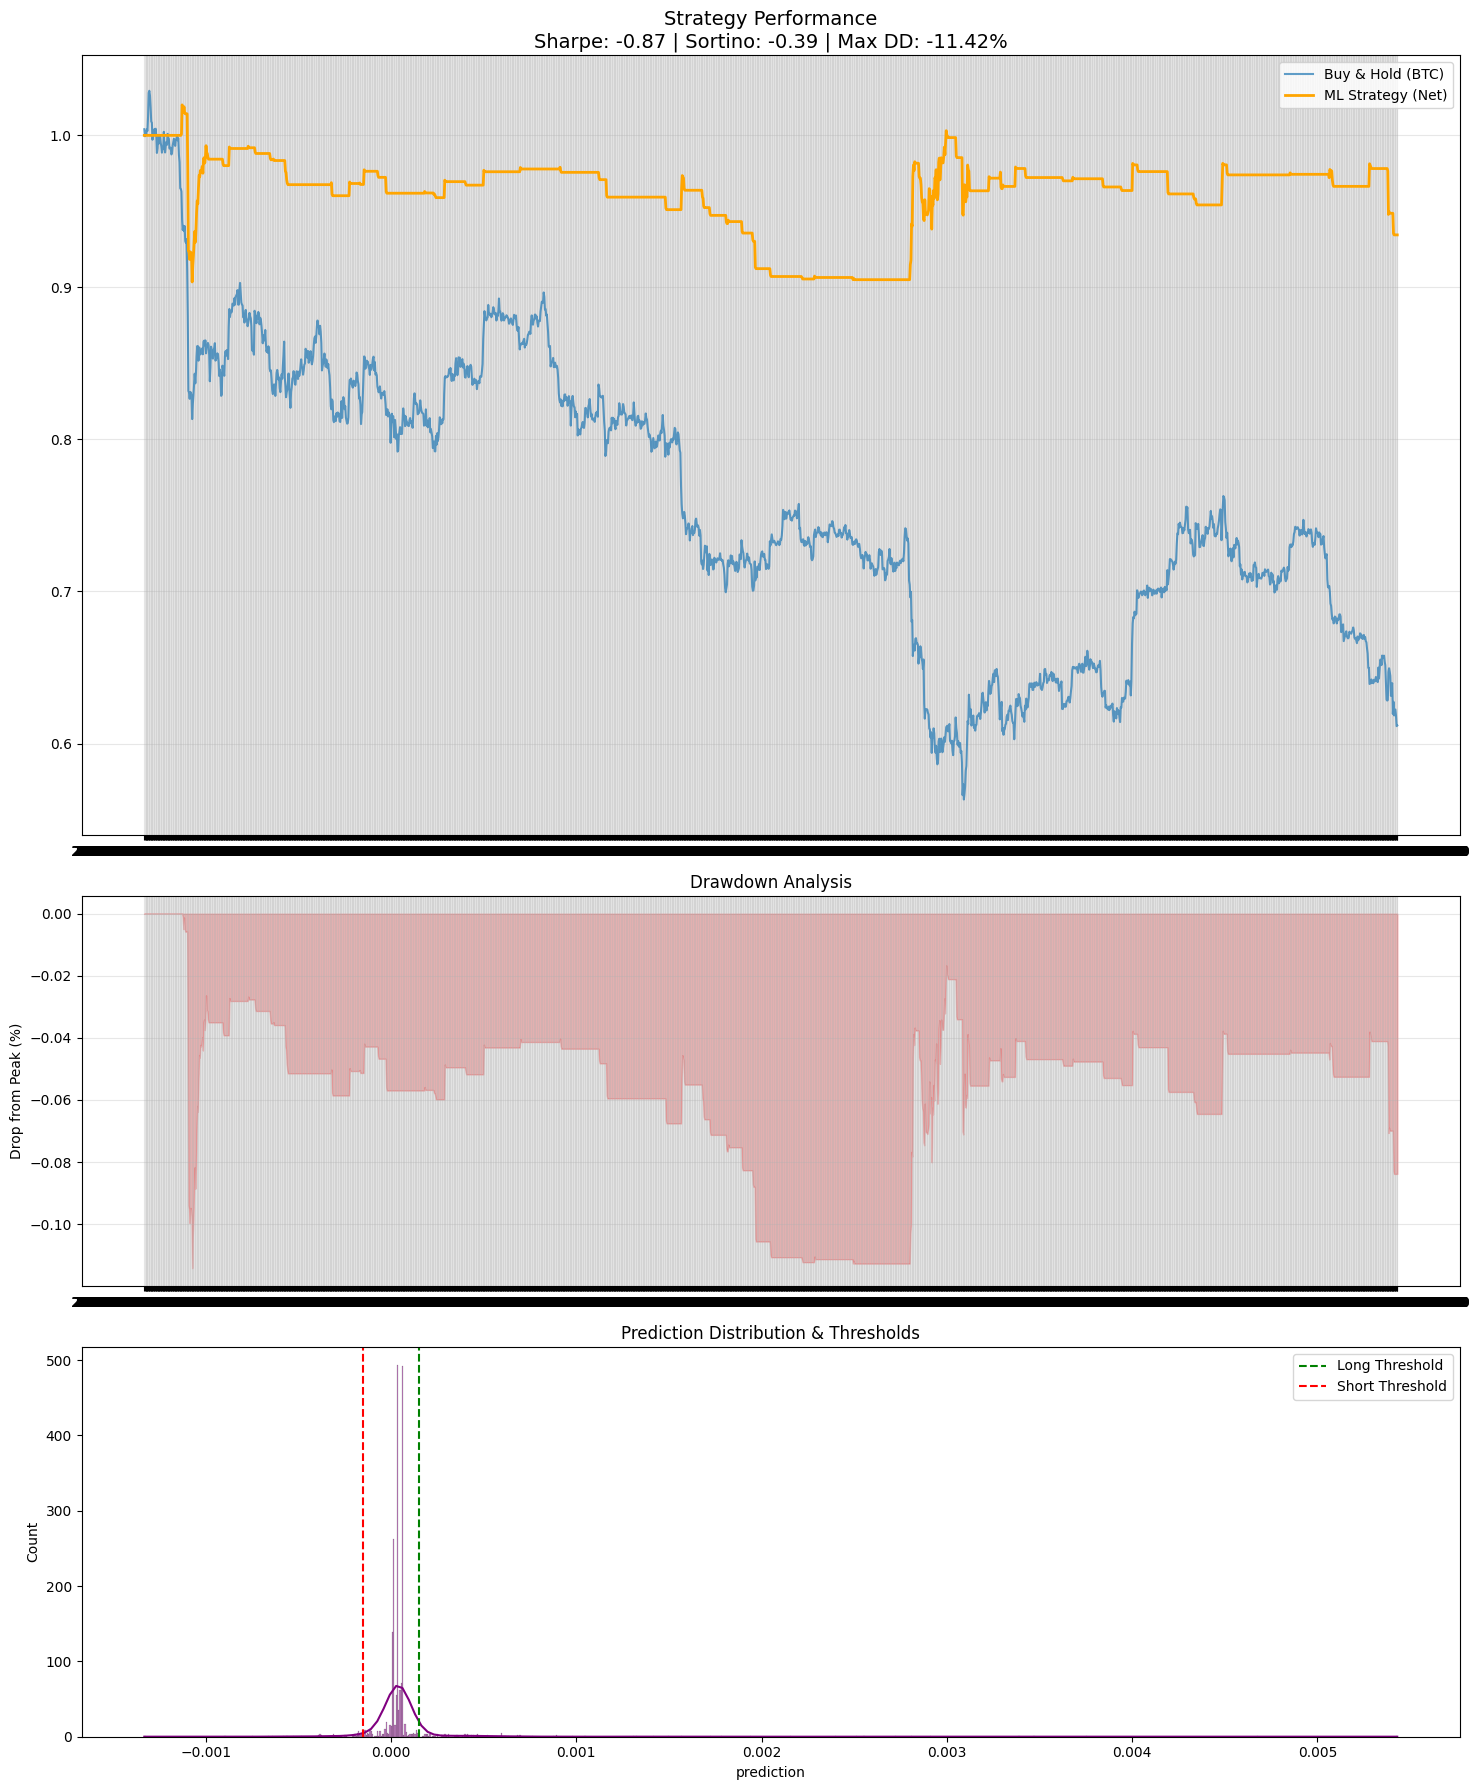

Total Trades Executed: 196.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# 1. Load data and model
project_path = "/content/drive/MyDrive/Crypto_ML_Project"
df = pd.read_csv(f"{project_path}/BTC_1H_processed.csv")
split_index = int(len(df) * 0.8)
test_df = df.iloc[split_index:].copy()

import xgboost as xgb
model = xgb.XGBRegressor()
model.load_model(f"{project_path}/xgboost_btc_model.json")

# 2. Generate Predictions
features = ['rsi', 'stoch_osc', 'atr', 'bb_width', 'ema_diff', 'return_1h', 'return_4h', 'return_24h']
test_df['prediction'] = model.predict(test_df[features])

# 3. SET THE CONFIDENCE THRESHOLD
# Only trade if the predicted return is greater than X%
# This reduces over-trading and saves on fees.
threshold = test_df['prediction'].std() * 0.5
print(f"Confidence Threshold set at: {threshold:.6f}")

test_df['signal'] = 0
test_df.loc[test_df['prediction'] > threshold, 'signal'] = 1   # Long
test_df.loc[test_df['prediction'] < -threshold, 'signal'] = -1 # Short

# 4. Calculate Returns and Fees
fees = 0.001
test_df['strategy_return'] = test_df['signal'] * test_df['target']
test_df['trades'] = test_df['signal'].diff().fillna(0).abs()
test_df['strategy_net_return'] = test_df['strategy_return'] - (test_df['trades'] * fees)

# 5. Cumulative Wealth
test_df['cum_bh_return'] = (1 + test_df['target']).cumprod()
test_df['cum_strategy_return'] = (1 + test_df['strategy_net_return']).cumprod()

# 6. RISK METRICS CALCULATION
def calculate_metrics(returns):
    sharpe = (returns.mean() / returns.std()) * np.sqrt(24 * 365) # Annualized
    downside_returns = returns[returns < 0]
    sortino = (returns.mean() / downside_returns.std()) * np.sqrt(24 * 365)
    cum_ret = (1 + returns).prod() - 1

    # Drawdown
    cum_wealth = (1 + returns).cumprod()
    running_max = cum_wealth.cummax()
    drawdown = (cum_wealth - running_max) / running_max
    max_dd = drawdown.min()

    return sharpe, sortino, cum_ret, max_dd, drawdown

sharpe, sortino, total_ret, max_dd, dd_series = calculate_metrics(test_df['strategy_net_return'])

# 7. MULTI-PLOT VISUALIZATION
fig, axs = plt.subplots(3, 1, figsize=(15, 18), gridspec_kw={'height_ratios': [2, 1, 1]})

# Plot 1: Equity Curve
axs[0].plot(test_df['timestamp'], test_df['cum_bh_return'], label='Buy & Hold (BTC)', alpha=0.7)
axs[0].plot(test_df['timestamp'], test_df['cum_strategy_return'], label='ML Strategy (Net)', color='orange', linewidth=2)
axs[0].set_title(f"Strategy Performance\nSharpe: {sharpe:.2f} | Sortino: {sortino:.2f} | Max DD: {max_dd:.2%}", fontsize=14)
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Plot 2: Drawdown (The "Pain" Chart)
axs[1].fill_between(test_df['timestamp'], dd_series, 0, color='red', alpha=0.3)
axs[1].set_title("Drawdown Analysis", fontsize=12)
axs[1].set_ylabel("Drop from Peak (%)")
axs[1].grid(True, alpha=0.3)

# Plot 3: Prediction Distribution
sns.histplot(test_df['prediction'], kde=True, ax=axs[2], color='purple')
axs[2].axvline(threshold, color='green', linestyle='--', label='Long Threshold')
axs[2].axvline(-threshold, color='red', linestyle='--', label='Short Threshold')
axs[2].set_title("Prediction Distribution & Thresholds", fontsize=12)
axs[2].legend()

plt.tight_layout()
plt.show()

print(f"Total Trades Executed: {test_df['trades'].sum()}")